In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import Sequential

from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Input, Lambda, LSTM

In [2]:
#fetch dataset

df = pd.read_excel("well3.xlsx", index_col="DATEPRD")
date = df.index

df.head()

,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL
DATEPRD,,,,,,,,,,,
2008-02-12,308.055940,104.418090,201.250000,18.639557,14.484431,106.805939,16.294718,92.475107,284.65,38888.67,385.01
2008-02-13,303.033518,105.402696,182.144942,16.466641,22.832986,120.888576,53.374330,89.620148,1869.70,285246.16,7.13
2008-02-14,295.586061,105.775486,181.867887,12.659589,31.249966,113.718175,72.737631,80.120465,3124.09,509954.88,1.16
2008-02-15,297.662702,105.751875,180.832060,5.264052,28.518930,116.830642,69.995943,84.250990,2608.28,383426.67,0.97
2008-02-16,295.935519,105.811114,180.501045,12.384634,30.227902,115.434474,71.518347,82.359026,3051.80,418474.00,4.89


In [30]:
#function to plot the a series
def plot_series(x, y, format="-", start=None, end=None, label=None):
    plt.plot(x[start:end], y[start:end], format, label=label)
    plt.xlabel("Date")
    plt.ylabel("Oil Volume")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

    
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)


class ResetStatesCallback(Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

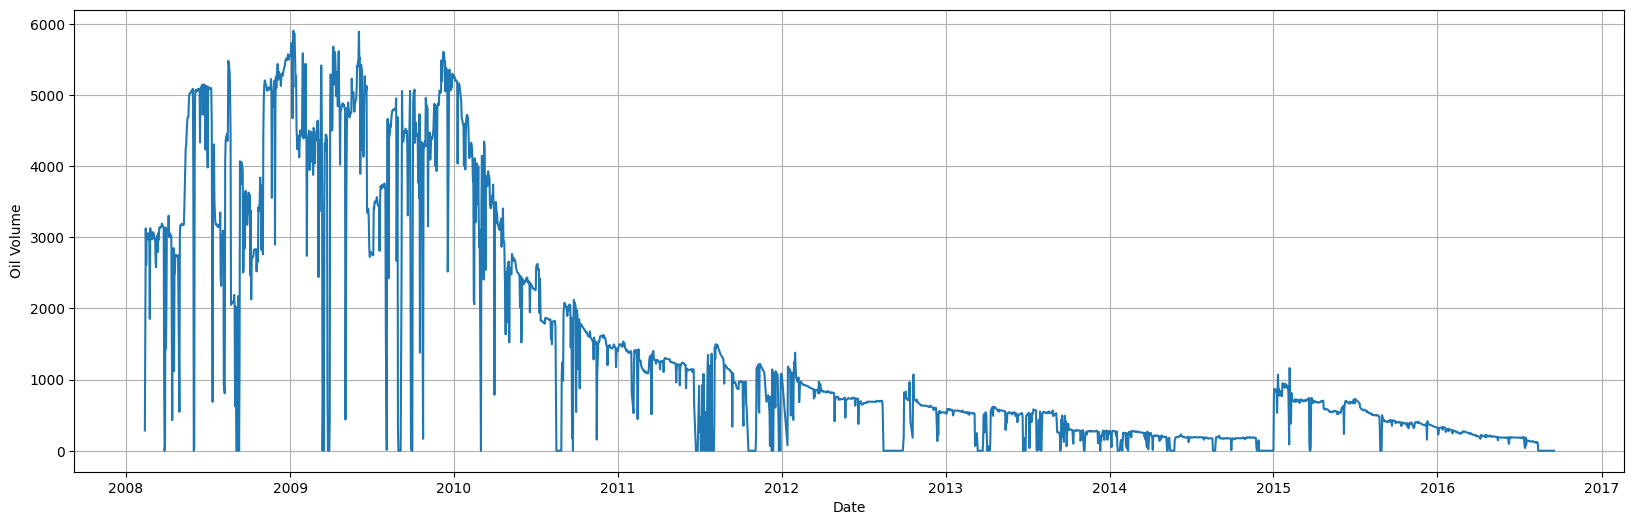

array([ 284.65, 1869.7 , 3124.09, ...,    0.  ,    0.  ,    0.  ])

In [23]:
oil_data = df.BORE_OIL_VOL.to_numpy()

plt.figure(figsize=(20, 6))
plot_series(date, oil_data)
plt.show()

oil_data

In [25]:
#split the time series into training and validation sets
split_date = 2750

date_train = date[:split_date]
date_valid = date[split_date:]

x_train = oil_data[:split_date]
x_valid = oil_data[split_date:]

print(x_train.shape, x_valid.shape, date_train.shape, date_valid.shape)

(2750,) (306,) (2750,) (306,)


# RNN Model - LSTM

In [36]:
#clear session 
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = Sequential([
    
        LSTM(100, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
        LSTM(100, return_sequences=True, stateful=True),
        Dense(1)
        #Lambda(lambda x: x * 200.0)
    
    ])

learning_rate_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

reset_states = ResetStatesCallback()

optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)

model.compile(loss=keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[learning_rate_schedule, reset_states])

Epoch 1/100
91/91 [==============================] - 7s 19ms/step - loss: 1650.9897 - mae: 1651.4656
Epoch 2/100
91/91 [==============================] - 2s 18ms/step - loss: 1650.9862 - mae: 1651.4637
Epoch 3/100
91/91 [==============================] - 2s 18ms/step - loss: 1650.9840 - mae: 1651.4597
Epoch 4/100
91/91 [==============================] - 2s 18ms/step - loss: 1650.9813 - mae: 1651.4573
Epoch 5/100
91/91 [==============================] - 2s 19ms/step - loss: 1650.9788 - mae: 1651.4546: 1s - loss: 3
Epoch 6/100
91/91 [==============================] - 2s 21ms/step - loss: 1650.9760 - mae: 1651.4518
Epoch 7/100
91/91 [==============================] - 2s 19ms/step - loss: 1650.9733 - mae: 1651.4495
Epoch 8/100
91/91 [==============================] - 2s 18ms/step - loss: 1650.9706 - mae: 1651.4459
Epoch 9/100
91/91 [==============================] - 2s 18ms/step - loss: 1650.9683 - mae: 1651.4443: 1s - loss: 
Epoch 10/100
91/91 [==============================] - 2s 18ms/st

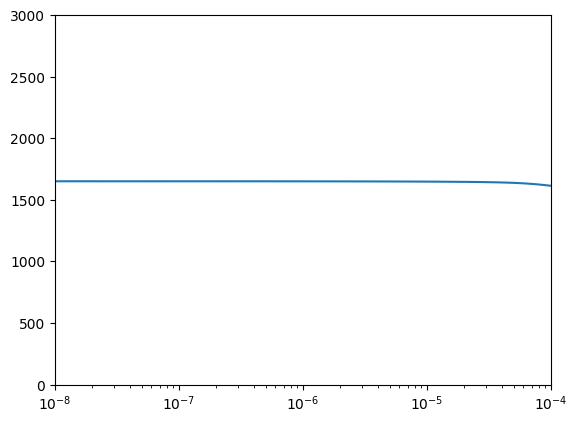

dict_keys(['loss', 'mae', 'lr'])


In [59]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 3000])
plt.show()

print(history.history.keys())

#univariate

In [ ]:
# specify the window size
n_steps = 7

# split into samples
X, y = split_sequence(values, n_steps)

# reshape into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# define model
model = Sequential()

model.add(Input(shape=(X_train.shape[1],)))

In [ ]:
model.add(LSTM(100, activation='relu', kernel_initializer='he_normal'))

In [ ]:
model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# fit the model
model.fit(X_train, y_train, epochs=350, batch_size=32, verbose=2, validation_data=(X_test, y_test))

# evaluate the model
mse, mae = model.evaluate(X_test, y_test, verbose=0)
print('MSE: %.3f, RMSE: %.3f, MAE: %.3f' % (mse, sqrt(mse), mae))

# make a prediction


In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

#  MLP

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# determine the number of input & output features
features_in = X_train.shape[1]
features_out = y_train.shape[1]

# define model
mlp = Sequential()

mlp.add(Input(shape=(features_in,)))

mlp.add(Dense(10, activation='relu', kernel_initializer='he_normal'))
mlp.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
mlp.add(Dense(features_out))

# compile the model
mlp.compile(optimizer='adam', loss='mse')

# fit the model
mlp.fit(X_train, y_train, epochs=150, batch_size=32, verbose=0)

# evaluate the model
error = mlp.evaluate(X_test, y_test, verbose=2)
print('MSE: %.3f, RMSE: %.3f' % (error, sqrt(error)))
